<a href="https://colab.research.google.com/github/faynercosta/faynercosta/blob/main/Final_Solution_HODL_SP23_Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

# **Introduction**

Your goal in this exercise is to detect emotion from a facial image. To that end, we will use the 2013 Facial Expression Recognition (FER) dataset. 

The dataset consists of ~36,000 images, each annotated with one of seven labels:
* angry
* disgust
* fear
* happy
* sad
* surprise
* neutral 

We will do two things:

1) Build a Convolutional Neural Network (CNN) *from scratch* to detect emotion in facial images.  
2) Use transfer learning to customize a pretrained model to solve the same problem. 

But first, let's get the data.

In [2]:
!wget -q -P ./ https://www.dropbox.com/s/ia62dg6kpp3q8wb/fer2013.csv

In [3]:
data = pd.read_csv('/content/fer2013.csv')

In [4]:
data.shape

(35887, 3)

In [5]:
data.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [6]:
print(data.loc[0,'pixels'])

70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92 

The pixel values for each image is provided as a space-separated list of numbers. How many pixels in an image?

In [7]:
len(data.loc[0, 'pixels'].split(' '))

2304

So each (gray-scale) image is encoded as a list of 2304 pixels. We will reshape this into an 48x48 image next.

In [8]:
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # read each face as a 1-d array 
    face = np.asarray(face).reshape(width, height) # reshape the length 2304 1-d array into an 48x48 array
    face = np.stack((face,)*3, axis=-1) # convert single channel to three channels simply by replicating the single channel we have. 
    faces.append(face.astype('float32'))
faces = np.asarray(faces)

Next, let's take a look at how emotion is encoded.

In [9]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

Ok, so it is sparse encoded.

Just for practice, we will change the sparse coding to one-hot encoding.

In [10]:
emotions = pd.get_dummies(data['emotion']).to_numpy() # each emotion is 'one-hot' encoded as a 7-dim vector
emotions_names = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') 

Lets take a look at some of these fun images! 

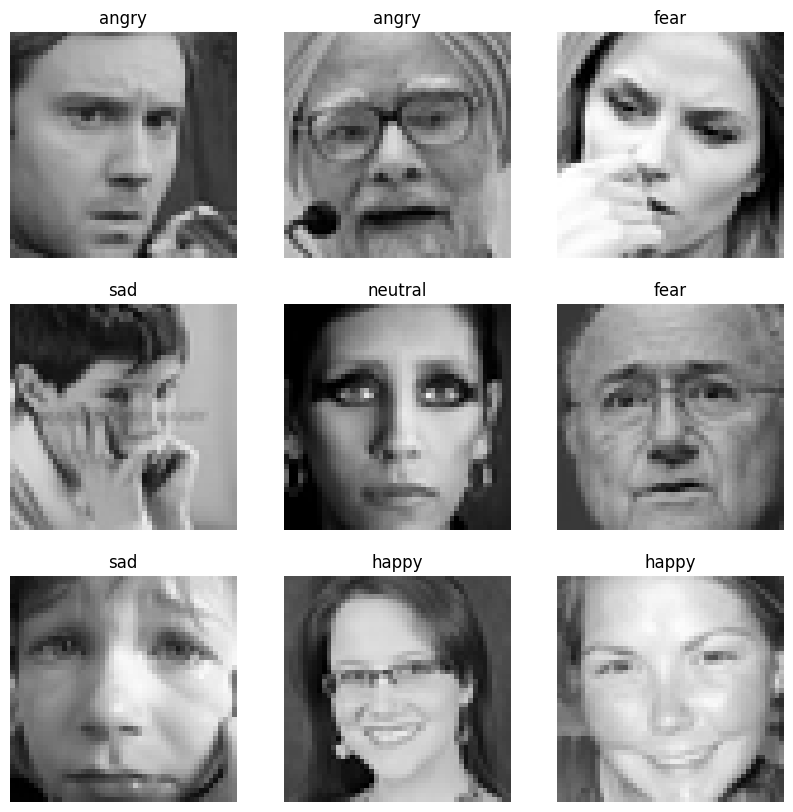

In [11]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(f"{emotions_names[np.argmax(emotions[i])]}")
    ax.imshow(faces[i].astype('uint8'))
    ax.axis('off')

As in the original dataset, we will reserve the first 28,709 images for training and the rest for testing. 

In [12]:
train_faces, train_emotions =  faces[:28709], emotions[:28709]
test_faces, test_emotions =  faces[28709:], emotions[28709:]

In [13]:
print(train_faces.shape, train_emotions.shape)

(28709, 48, 48, 3) (28709, 7)


In [14]:
print(test_faces.shape, test_emotions.shape)

(7178, 48, 48, 3) (7178, 7)


# Problem 1

We will try a simple CNN on this dataset with three convolutional blocks + one dense layer + output layer.

In [21]:
input = keras.Input(shape=train_faces.shape[1:])
x = keras.layers.Rescaling(1./255)(input) #normalizing
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_3")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)   
output = keras.layers.Dense(7, activation="softmax", name="output")(x)

model = keras.Model(input, output, name='CNN_model')

In [22]:
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 Conv_1 (Conv2D)             (None, 47, 47, 32)        416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 Conv_2 (Conv2D)             (None, 22, 22, 32)        4128      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                     

In [23]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Since we one-hot-encoded the dependent variable, we use `categorical_crossentropy`, not `sparse_categorical_crossentropy`.👆.

In [24]:
epochs = 30
history = model.fit(train_faces, train_emotions, 
          batch_size=64, 
          epochs=epochs, 
          validation_split=0.2)

Epoch 1/30
359/359 [==============================] - 5s 8ms/step - loss: 1.6857 - accuracy: 0.3266 - val_loss: 1.5548 - val_accuracy: 0.4068
Epoch 2/30
359/359 [==============================] - 3s 8ms/step - loss: 1.4685 - accuracy: 0.4399 - val_loss: 1.4197 - val_accuracy: 0.4591
Epoch 3/30
359/359 [==============================] - 2s 6ms/step - loss: 1.3655 - accuracy: 0.4752 - val_loss: 1.3288 - val_accuracy: 0.4949
Epoch 4/30
359/359 [==============================] - 2s 6ms/step - loss: 1.2884 - accuracy: 0.5073 - val_loss: 1.2881 - val_accuracy: 0.5111
Epoch 5/30
359/359 [==============================] - 2s 7ms/step - loss: 1.2223 - accuracy: 0.5347 - val_loss: 1.2926 - val_accuracy: 0.5110
Epoch 6/30
359/359 [==============================] - 2s 6ms/step - loss: 1.1530 - accuracy: 0.5642 - val_loss: 1.2679 - val_accuracy: 0.5199
Epoch 7/30
359/359 [==============================] - 3s 8ms/step - loss: 1.0784 - accuracy: 0.5973 - val_loss: 1.2385 - val_accuracy: 0.5359
Epoch 

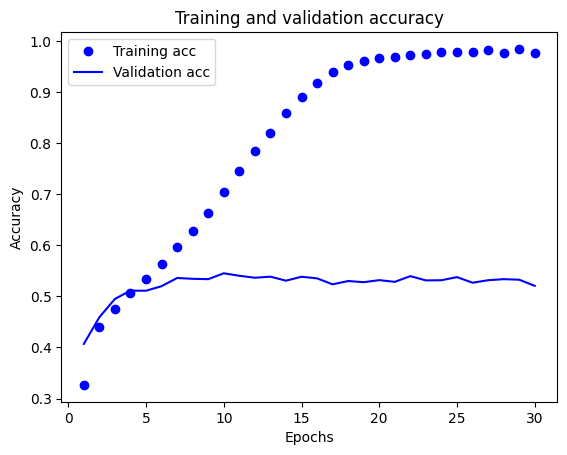

In [25]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

What's the test accuracy?

In [26]:
# Insert your code below and execute this cell
score = model.evaluate(test_faces, test_emotions)
print("Test accuracy:", score[1])

225/225 [==============================] - 1s 3ms/step - loss: 3.8481 - accuracy: 0.5184
Test accuracy: 0.5183895230293274


# Problem 2

Add an additional dense layer to the CNN from Problem 1.

In [27]:
input = keras.Input(shape=train_faces.shape[1:])
x = keras.layers.Rescaling(1./255)(input) #normalizing
x = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_1")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_2")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(16, kernel_size=(2, 2), activation="relu", name="Conv_3")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(256, activation="relu")(x)
output = keras.layers.Dense(7, activation="softmax", name="output")(x)

model2 = keras.Model(input, output, name='CNN_model2')

In [28]:
model2.summary()

Model: "CNN_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 Conv_1 (Conv2D)             (None, 47, 47, 16)        208       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 Conv_2 (Conv2D)             (None, 22, 22, 16)        1040      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                    

In [29]:
model2.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [30]:
epochs = 30
history = model2.fit(train_faces, train_emotions, 
          batch_size=64, 
          epochs=epochs, 
          validation_split=0.2)

Epoch 1/30
359/359 [==============================] - 5s 8ms/step - loss: 1.7390 - accuracy: 0.2913 - val_loss: 1.6273 - val_accuracy: 0.3699
Epoch 2/30
359/359 [==============================] - 3s 8ms/step - loss: 1.5509 - accuracy: 0.3971 - val_loss: 1.4844 - val_accuracy: 0.4343
Epoch 3/30
359/359 [==============================] - 3s 7ms/step - loss: 1.4585 - accuracy: 0.4336 - val_loss: 1.4185 - val_accuracy: 0.4493
Epoch 4/30
359/359 [==============================] - 2s 7ms/step - loss: 1.3843 - accuracy: 0.4699 - val_loss: 1.3662 - val_accuracy: 0.4713
Epoch 5/30
359/359 [==============================] - 2s 7ms/step - loss: 1.3267 - accuracy: 0.4911 - val_loss: 1.3587 - val_accuracy: 0.4848
Epoch 6/30
359/359 [==============================] - 2s 7ms/step - loss: 1.2727 - accuracy: 0.5167 - val_loss: 1.3267 - val_accuracy: 0.4970
Epoch 7/30
359/359 [==============================] - 3s 8ms/step - loss: 1.2108 - accuracy: 0.5420 - val_loss: 1.3099 - val_accuracy: 0.5042
Epoch 

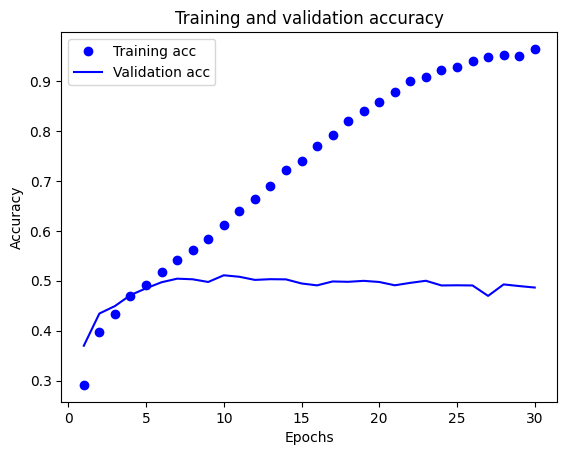

In [31]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

What's the test accuracy?

In [32]:
# Insert your code below and execute this cell
# Insert your code below and execute this cell
score = model2.evaluate(test_faces, test_emotions)
print("Test accuracy:", score[1])

225/225 [==============================] - 1s 3ms/step - loss: 3.9496 - accuracy: 0.4882
Test accuracy: 0.488158255815506


# Problem 3

***Data Augmentation:*** 

The basic idea of augmentation is to alter the image so slightly that the value of the dependent variable (i.e. the category that it belongs to) doesn't change.

In [33]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomZoom(0.2),
    ]
)

Lets quickly visualize what the augmentation does ... 

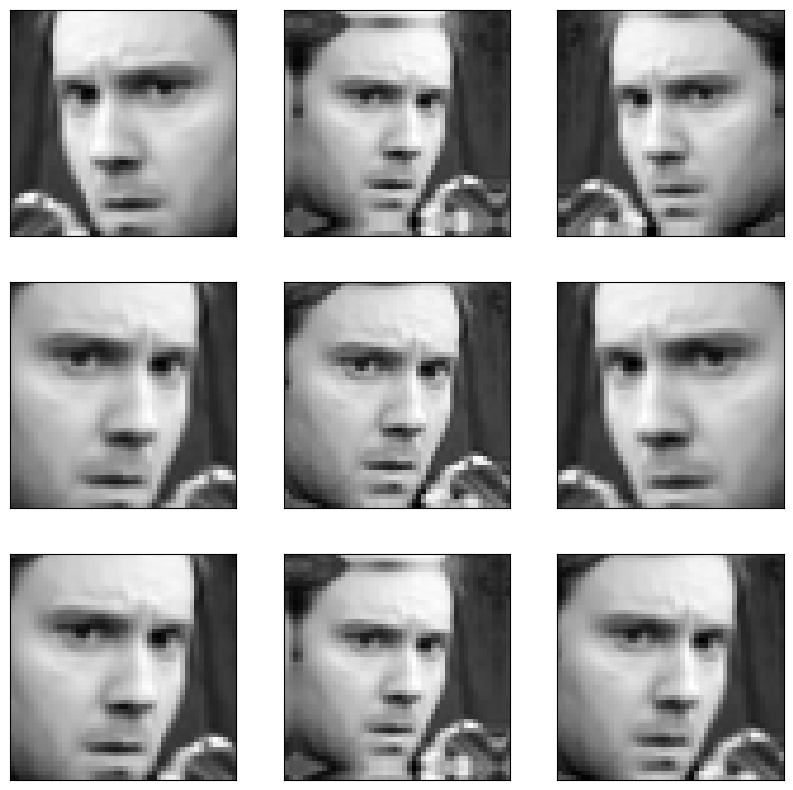

In [34]:
augmented_images = [data_augmentation(np.expand_dims(train_faces[0],axis=0)) for i in range(9)]
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(tf.keras.preprocessing.image.array_to_img(augmented_images[i][0]))

In [35]:
input = keras.Input(shape=train_faces.shape[1:])

x = data_augmentation(input)  

x = keras.layers.Rescaling(1./255)(x)

x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_3")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)   
output = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(input, output, name='augmented_CNN_model')

In [36]:
model.summary()

Model: "augmented_CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 Conv_1 (Conv2D)             (None, 47, 47, 32)        416       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 Conv_2 (Conv2D)             (None, 22, 22, 32)        4128      
                                               

In [37]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [38]:
epochs = 30
history = model.fit(train_faces, train_emotions, 
          batch_size=64, 
          epochs=epochs, 
          validation_split=0.2)

Epoch 1/30
359/359 [==============================] - 5s 10ms/step - loss: 1.7220 - accuracy: 0.3025 - val_loss: 1.6104 - val_accuracy: 0.3750
Epoch 2/30
359/359 [==============================] - 3s 8ms/step - loss: 1.5663 - accuracy: 0.3918 - val_loss: 1.4719 - val_accuracy: 0.4312
Epoch 3/30
359/359 [==============================] - 3s 7ms/step - loss: 1.4712 - accuracy: 0.4302 - val_loss: 1.3966 - val_accuracy: 0.4608
Epoch 4/30
359/359 [==============================] - 3s 7ms/step - loss: 1.4025 - accuracy: 0.4602 - val_loss: 1.3350 - val_accuracy: 0.4956
Epoch 5/30
359/359 [==============================] - 3s 7ms/step - loss: 1.3517 - accuracy: 0.4764 - val_loss: 1.2873 - val_accuracy: 0.5146
Epoch 6/30
359/359 [==============================] - 3s 9ms/step - loss: 1.3105 - accuracy: 0.4948 - val_loss: 1.2773 - val_accuracy: 0.5071
Epoch 7/30
359/359 [==============================] - 3s 7ms/step - loss: 1.2732 - accuracy: 0.5124 - val_loss: 1.2571 - val_accuracy: 0.5289
Epoch

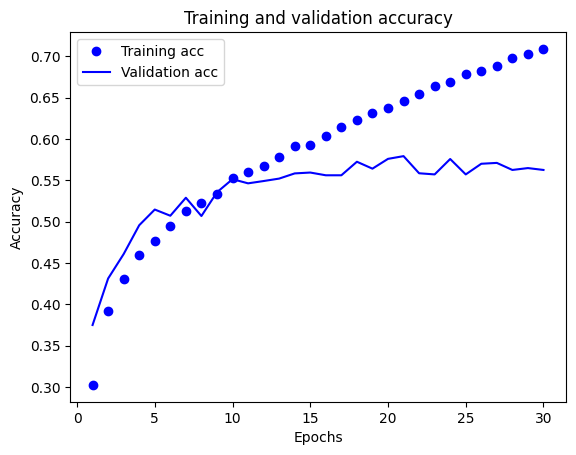

In [39]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

What's the test accuracy?

In [40]:
# Insert your code below and execute this cell
score = model.evaluate(test_faces, test_emotions)
print("Test accuracy:", score[1])


225/225 [==============================] - 1s 3ms/step - loss: 1.3496 - accuracy: 0.5577
Test accuracy: 0.5576762557029724


# Problem 4

Next, we apply transfer learning to our problem. We will take a slightly different approach from what we saw in class: instead of running each image through a pre-trained "headless" model to get smart representations and then using them as the input to our own "little" NN, we will do the following: we will (a) remove the top from an existing pre-trained model to get a "headless" model (b) "attach" our little NN to to this "headless" model and (c) train this **entire** model. 


Why? So that we can 'fine-tune' the weights of the original pre-trained model (along with the weights of our "little" NN) to better minimize our loss function.

***Overall Approach*** 

In class, we used ResNet50. In this problem, we will use another pretrained model called [VGG19](https://keras.io/api/applications/vgg/).
 

1.   We will remove the top of VGG19 to make it "headless". We will refer to this as the "base model".
2.   We will create a little NN and connect the output of the base model to this little NN.
3. ** We will unfreeze the last 10 layers of the base model so that SGD/Adam can optimize those weights as well.** 



In [82]:
# We will define a function that will build a model per the approach above

def construct_model(no_classes, input_shape, metrics=['accuracy']):

  base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
  )

  # Freeze the base_model
  base_model.trainable = False

  
  inputs = keras.Input(shape=input_shape)

  x = keras.layers.Rescaling(1./255)(inputs) #normalizing

  # Apply random data augmentation
  x = data_augmentation(x)  

  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here. We didn't cover batchnorm 
  # layers in class so just take our word for it :-)
  x = base_model(x, training=False)
  
  # Next we connect the output from our headless model to our little NN
  # we will flatten the output of the headless
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  outputs = keras.layers.Dense(no_classes, activation='softmax')(x)
  

  model = keras.Model(inputs, outputs)
  model.summary()

  # unfreeze the last 10 layers of the model so that we can 
  # optimize the weights of those layers (along with the weights
  # of the layers of the little NN)

  for layer in model.layers[-10:]:
      if not isinstance(layer, keras.layers.BatchNormalization): #the batch normalization layer is untouched 
          layer.trainable = True

  model.compile(loss='categorical_crossentropy', 
                optimizer=keras.optimizers.Adam(0.2*1e-4), #here we choose a different rate for Adam than default for better convergence
                metrics=metrics) 
  
  return model

***Training the Overall Model***

In [83]:
no_classes = 7
NUM_EPOCHS = 30
model = construct_model(no_classes,(48,48,3))

history = model.fit(train_faces, train_emotions, epochs=NUM_EPOCHS, validation_split=0.2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 dense_13 (Dense)            (None, 1024)              1049

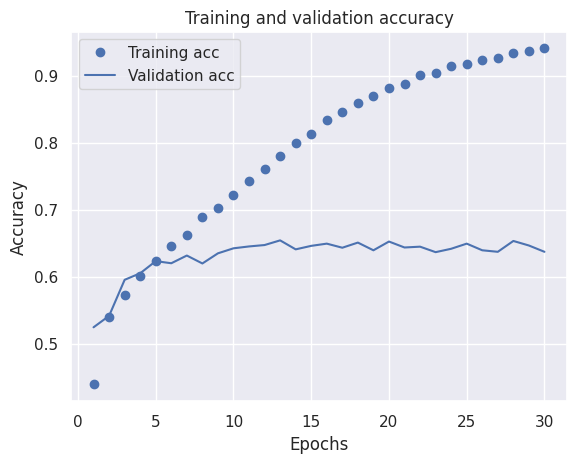

In [84]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Let's calc the accuracy on the test set.

In [89]:
# Insert your code below and execute this cell
score = model.evaluate(test_faces, test_emotions)
print("Test accuracy:", score[1])

225/225 [==============================] - 4s 16ms/step - loss: 1.6967 - accuracy: 0.6326
Test accuracy: 0.6326274871826172


The accuracy for the testing set has improved significantly. Note, however, that the state-of-the-art for this dataset is around 73.3%.

Let's calculate the confusion matrix.

In [86]:
predictions_index = model.predict(test_faces).argmax(axis=1)
actuals_index = test_emotions.argmax(axis=1)

actuals = [emotions_names[i] for i in actuals_index]
predictions = [emotions_names[i] for i in predictions_index]


225/225 [==============================] - 4s 15ms/step


In [87]:
df = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})
a=pd.crosstab(df.Predictions, df.Actuals)
a

Actuals,angry,disgust,fear,happy,neutral,sad,surprise
Predictions,,,,,,,
angry,516,22,100,42,84,157,15
disgust,11,64,6,0,0,3,0
fear,164,12,595,40,131,233,121
happy,57,1,42,1531,123,93,50
neutral,111,5,106,95,738,253,24
sad,84,6,121,41,124,489,13
surprise,15,1,54,25,33,19,608


To help with interpretability, we can plot a heatmap of the confusion matrix as well.

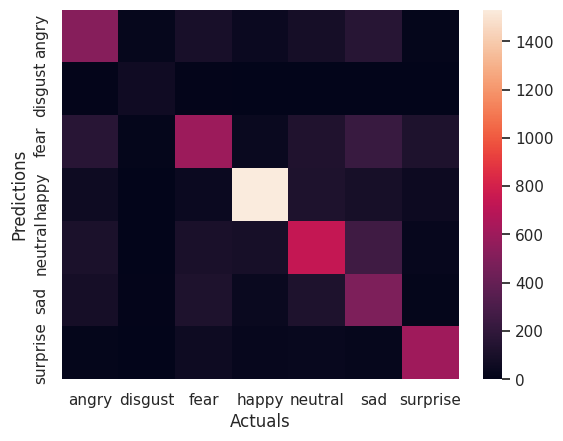

In [88]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

ax = sns.heatmap(a)

# Problem 5
It is now your turn. 

Take the code for Problem 4 and modify it so that it uses ResNet50 as the base model and not VGG19. Answer the questions in the Homework document.

In [48]:
# We will define a function that will build a model per the approach above

def construct_model2(no_classes, input_shape, metrics=['accuracy']):

  base_model = keras.applications.ResNet50(
    include_top=False,  
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
  )

  # Freeze the base_model
  base_model.trainable = False

  
  inputs = keras.Input(shape=input_shape)

  x = keras.layers.Rescaling(1./255)(inputs) #normalizing

  # Apply random data augmentation
  x = data_augmentation(x)  

  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here. We didn't cover batchnorm 
  # layers in class so just take our word for it :-)
  x = base_model(x, training=False)
  
  # Next we connect the output from our headless model to our little NN
  # we will flatten the output of the headless
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  outputs = keras.layers.Dense(no_classes, activation='softmax')(x)
  

  model = keras.Model(inputs, outputs)
  model.summary()

  # unfreeze the last 10 layers of the model so that we can 
  # optimize the weights of those layers (along with the weights
  # of the layers of the little NN)

  for layer in model.layers[-10:]:
      if not isinstance(layer, keras.layers.BatchNormalization): #the batch normalization layer is untouched 
          layer.trainable = True

  model.compile(loss='categorical_crossentropy', 
                optimizer=keras.optimizers.Adam(0.2*1e-4), #here we choose a different rate for Adam than default for better convergence
                metrics=metrics) 
  
  return model

In [49]:
no_classes = 7
NUM_EPOCHS = 30
model2 = construct_model2(no_classes,(48,48,3))

history2 = model2.fit(train_faces, train_emotions, epochs=NUM_EPOCHS, validation_split=0.2)

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              8389632   
                                                            

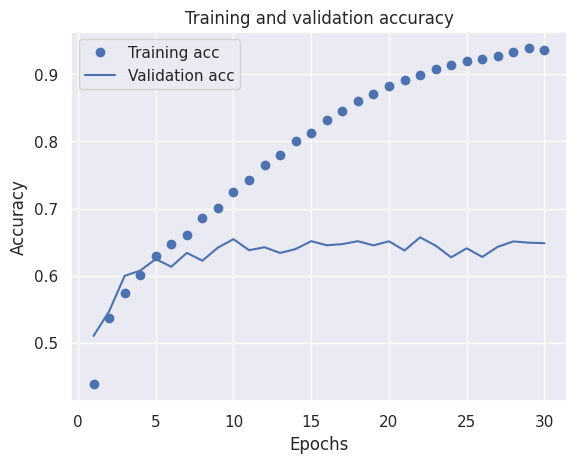

In [50]:
history_dict2 = history2.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [51]:
# Insert your code below and execute this cell
score = model2.evaluate(test_faces, test_emotions)
print("Test accuracy:", score[1])

225/225 [==============================] - 1s 4ms/step - loss: 5.1696 - accuracy: 0.4763
Test accuracy: 0.47631651163101196


In [52]:
predictions_index = model2.predict(test_faces).argmax(axis=1)
actuals_index = test_emotions.argmax(axis=1)

actuals = [emotions_names[i] for i in actuals_index]
predictions = [emotions_names[i] for i in predictions_index]


225/225 [==============================] - 1s 2ms/step


In [53]:
df = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})
a=pd.crosstab(df.Predictions, df.Actuals)
a

Actuals,angry,disgust,fear,happy,neutral,sad,surprise
Predictions,,,,,,,
angry,407,28,160,148,159,227,54
disgust,12,45,11,7,9,5,2
fear,117,11,330,87,114,159,70
happy,109,7,102,1124,142,137,54
neutral,126,10,133,187,555,250,63
sad,143,8,184,165,208,413,43
surprise,44,2,104,56,46,56,545


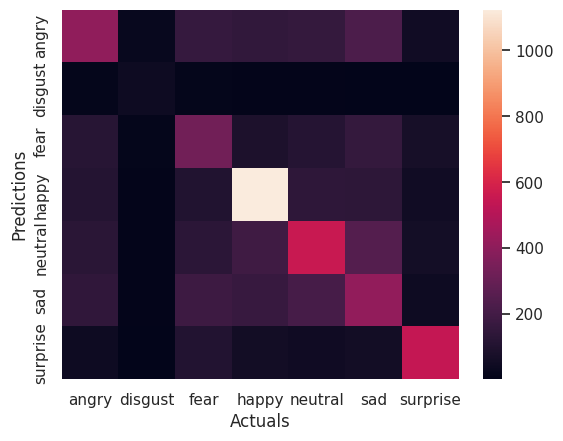

In [54]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

ax = sns.heatmap(a)

# Bonus Question
Run on your face's image

In [107]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(48,48))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = tf.keras.applications.vgg16.preprocess_input(arr)
  arr = np.expand_dims(arr, axis=0)
  pred = model.predict(arr).argmax(axis=1)

  if (pred== 0):
    pred = 'angry'
  elif(pred==1):
    pred = 'disgust'
  elif(pred==2):
    pred = 'fear'
  elif(pred==3):
    pred = 'happy'
  elif(pred==4):
    pred='sad' 
  elif(pred==5):
    pred = 'surprise'
  elif(pred==6):
    pred = 'neutral'
  
  else: 
    print("Error on the prediction!!")
    pred = 'Error'
  return pred

1/1 [==============================] - 0s 109ms/step


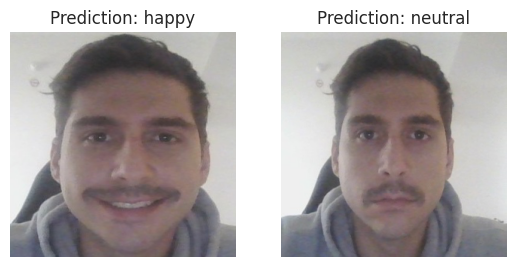

1/1 [==============================] - 0s 22ms/step


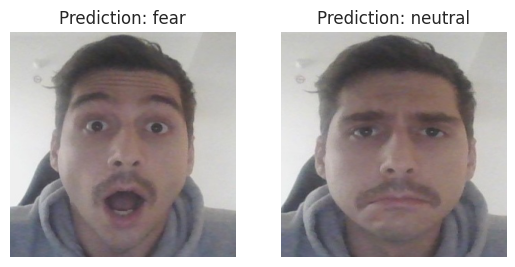

In [121]:
from IPython.display import Image
from PIL import Image


#Number of images
num_img = 4

for i in range(1, num_img+1):
    # Create the filename
    filename = "Img" + str(i) + ".jpg"
    
    # Load the image
    img = Image.open(filename)
    
    # Predict the image title
    pred = predict_image(filename)
    
    # Display the image with the predicted title
    img = img.resize((300, 300))
    plt.subplot(1, 2, i%2+1)
    plt.imshow(img)
    plt.title("Prediction: "+ pred)
    plt.grid(False)
    plt.axis('off')
    
    # Show two images per row
    if i%2 == 0 or i == num_img:
        plt.show()